## Introduction

This notebook is designed to develop a machine learning model for the detection of ovarian cancer. The main aim of this project is to utilise various machine learning methods. The code is organized into several sections.

1. [The Data Wrangling section](#data_wrang) preprocesses the dataset to transform raw data into a clean dataset suitable for training the machine learning model.
2. [The Preliminary Data Analysis section](#data_anal) explores the provided dataset and performs basic statistical analysis to better understand the data.
3. [The Feature Engineering section](#feature) extracts relevant features from the data to improve the accuracy of the model.
4. [The Model Training section](#training) trains the machine learning model using several ensemble learning algorithms and evaluates their performance based on various metrics.
5. [The Analysis of Ensemble Methods section](#model_anal) analyzes the factors that contribute to the performance of the selected ensemble learning algorithm.
6. Additionally, the code includes [an Explainable AI section](#xai) that uses various methods to interpret the machine learning model and provide insights into its decision-making process.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install mrmr_selection

/kaggle/input/predict-ovarian-cancer/Supplementary data 5.xlsx
/kaggle/input/predict-ovarian-cancer/Supplementary data 2.xlsx
/kaggle/input/predict-ovarian-cancer/Supplementary data 4.xlsx
/kaggle/input/predict-ovarian-cancer/Supplementary data 1.xlsx
/kaggle/input/predict-ovarian-cancer/Supplementary data 3.xlsx


In [2]:
# Pandas display options for easy viewing of dataframes
pd.set_option('display.width', 150)

In [3]:
# Reading the dataset
cancer_data = pd.read_excel('/kaggle/input/predict-ovarian-cancer/Supplementary data 1.xlsx', sheet_name='All Raw Data', dtype=str)
# Remove trailing whitespace from all string columns
cancer_data = cancer_data.apply(lambda x: x.str.rstrip() if x.dtype == "object" else x)

In [4]:
# Printing the first 5 rows of the data
print(cancer_data.head())

  SUBJECT_ID    AFP     AG Age   ALB ALP ALT AST BASO# BASO%  ...   NEU   PCT   PDW  PHOS  PLT   RBC   RDW  TBIL    TP     UA
0          1   3.58  19.36  47  45.4  56  11  24  0.01   0.3  ...  76.2  0.09  13.4  1.46   74  2.64  13.7   5.5  73.9  396.4
1          2  34.24  23.98  61  39.9  95   9  13  0.02   0.3  ...  76.5   0.3  11.2  1.09  304  4.89  12.7   6.8    72  119.2
2          3   1.50   18.4  39  45.4  77   9  18  0.03   0.6  ...  69.7  0.13  15.2  0.97  112  4.62    12  14.8  77.9  209.2
3          4   2.75   16.6  45  39.2  26  16  17  0.05  0.74  ...  65.5  0.25  17.4  1.25  339  4.01  14.6  10.9  66.1  215.6
4          5   2.36  19.97  45    35  47  21  27  0.01   0.1  ...  59.5  0.28  11.9  0.94  272   4.4  13.4   5.3  66.5    206

[5 rows x 51 columns]


In [5]:
# Printing the shape of the data
print(cancer_data.shape)

(349, 51)


In [6]:
# Printing the summary statistics of the data
print(cancer_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SUBJECT_ID  349 non-null    object
 1   AFP         327 non-null    object
 2   AG          348 non-null    object
 3   Age         349 non-null    object
 4   ALB         339 non-null    object
 5   ALP         339 non-null    object
 6   ALT         339 non-null    object
 7   AST         339 non-null    object
 8   BASO#       349 non-null    object
 9   BASO%       349 non-null    object
 10  BUN         349 non-null    object
 11  Ca          349 non-null    object
 12  CA125       332 non-null    object
 13  CA19-9      325 non-null    object
 14  CA72-4      109 non-null    object
 15  CEA         327 non-null    object
 16  CL          349 non-null    object
 17  CO2CP       348 non-null    object
 18  CREA        349 non-null    object
 19  TYPE        349 non-null    object
 20  DBIL      

### Data Wrangling <a class="anchor" id="data_wrang"></a>

This section of the code is responsible for preparing the dataset for analysis by cleaning, transforming, and restructuring the data into a usable format. This section involves handling missing data, dealing with outliers, and transforming variables to ensure they meet the assumptions of the analysis method. The goal is to create a reliable dataset that maximizes accuracy when using machine learning algorithms. Data wrangling is a critical step in the data analysis process, as the accuracy of the results depends heavily on the quality of the dataset used.

In [7]:
# Before converting column types, the column values should be handled for data inconsistency
cancer_data.loc[cancer_data['AFP'] == '>1210.00', 'AFP'] = '1210.00'
cancer_data.loc[cancer_data['AFP'] == '>1210', 'AFP'] = '1210.00'
cancer_data.loc[cancer_data['CA125'] == '>5000.00', 'CA125'] = '5000.00'
cancer_data.loc[cancer_data['CA19-9'] == '>1000.00', 'CA19-9'] = '1000.00'
cancer_data.loc[cancer_data['CA19-9'] == '>1000', 'CA19-9'] = '1000.00'
cancer_data.loc[cancer_data['CA19-9'] == '<0.600', 'CA19-9'] = '0.5'

In [8]:
# Convert object columns to float columns
for col in cancer_data.drop('TYPE', axis=1).select_dtypes(include=['object']).columns:
    cancer_data[col] = cancer_data[col].astype('float')
    
# Convert target column to integer
cancer_data['TYPE'] = cancer_data['TYPE'].astype('int64')

In [9]:
# Computing the ratio of missing data in each column
missing_ratio = cancer_data.isnull().mean()

# Displaying the ratio of missing data in each column
print(missing_ratio)

SUBJECT_ID    0.000000
AFP           0.063037
AG            0.002865
Age           0.000000
ALB           0.028653
ALP           0.028653
ALT           0.028653
AST           0.028653
BASO#         0.000000
BASO%         0.000000
BUN           0.000000
Ca            0.000000
CA125         0.048711
CA19-9        0.068768
CA72-4        0.687679
CEA           0.063037
CL            0.000000
CO2CP         0.002865
CREA          0.000000
TYPE          0.000000
DBIL          0.028653
EO#           0.000000
EO%           0.000000
GGT           0.028653
GLO           0.028653
GLU.          0.000000
HCT           0.000000
HE4           0.057307
HGB           0.000000
IBIL          0.028653
K             0.000000
LYM#          0.000000
LYM%          0.000000
MCH           0.000000
MCV           0.000000
Menopause     0.000000
Mg            0.000000
MONO#         0.000000
MONO%         0.000000
MPV           0.005731
Na            0.000000
NEU           0.260745
PCT           0.005731
PDW        

In [10]:
# Before handling missing data, lets put the missing data in another variable to perform analysis on later
cancer_data_missing = cancer_data.copy()

# Dropping columns with a missing data ratio greater than 0.5
#cols_to_drop = ['CA72-4', 'NEU']
cols_to_drop = ['CA72-4']
cancer_data = cancer_data.drop(cols_to_drop, axis=1)

# get columns with missing data
cols_with_missing = [col for col in cancer_data.columns if cancer_data[col].isnull().any()]

# impute missing data with median value
for col in cols_with_missing:
    median_val = cancer_data[col].median()
    cancer_data[col].fillna(median_val, inplace=True)
    
# Displaying the updated missing data ratio
print(cancer_data.isnull().mean())

SUBJECT_ID    0.0
AFP           0.0
AG            0.0
Age           0.0
ALB           0.0
ALP           0.0
ALT           0.0
AST           0.0
BASO#         0.0
BASO%         0.0
BUN           0.0
Ca            0.0
CA125         0.0
CA19-9        0.0
CEA           0.0
CL            0.0
CO2CP         0.0
CREA          0.0
TYPE          0.0
DBIL          0.0
EO#           0.0
EO%           0.0
GGT           0.0
GLO           0.0
GLU.          0.0
HCT           0.0
HE4           0.0
HGB           0.0
IBIL          0.0
K             0.0
LYM#          0.0
LYM%          0.0
MCH           0.0
MCV           0.0
Menopause     0.0
Mg            0.0
MONO#         0.0
MONO%         0.0
MPV           0.0
Na            0.0
NEU           0.0
PCT           0.0
PDW           0.0
PHOS          0.0
PLT           0.0
RBC           0.0
RDW           0.0
TBIL          0.0
TP            0.0
UA            0.0
dtype: float64


In [11]:
# also drop ID column
cancer_data.drop('SUBJECT_ID', inplace=True, axis=1)

### Feature Engineering <a class="anchor" id="feature"></a>

This section of the code refers to the process of selecting and transforming the relevant features of the data to create new features that better represent the problem domain.The purpose of feature engineering is to improve the performance of machine learning algorithms by reducing the noise in the data, increasing the accuracy of the predictions, and making the model more interpretable. It requires a deep understanding of the problem domain and the data being used, as well as knowledge of the available feature engineering techniques and their impact on the model's performance.

In [12]:
# split data into features (X) and target (y)
cancer_X_train = cancer_data.drop('TYPE', axis=1)
cancer_y_train = cancer_data['TYPE']

In [13]:
# select top 10 features using MRMR
from mrmr import mrmr_classif
selected_features = mrmr_classif(X=cancer_X_train, y=cancer_y_train, K=18)

100%|██████████| 18/18 [00:00<00:00, 34.26it/s]


### Preliminary Data Analysis <a class="anchor" id="data_anal"></a>

This section of the code involves an initial examination of the dataset to understand its structure, contents, and quality. This includes checking for the extent of missing or erroneous data, exploring the distribution of the variables, identifying any outliers, and computing summary statistics. The purpose of this section is to gain insights into the dataset and inform subsequent data processing steps. It also involves visualizing the data using various plotting techniques to reveal patterns or relationships between the variables.

In [14]:
selected_features

['Age',
 'CEA',
 'IBIL',
 'NEU',
 'Menopause',
 'CA125',
 'ALB',
 'HE4',
 'GLO',
 'LYM%',
 'AST',
 'PLT',
 'HGB',
 'ALP',
 'LYM#',
 'PCT',
 'Ca',
 'CA19-9']

In [15]:
# Visualizing the correlation between the features in the training data
selected_cols = selected_features + ['TYPE']

# Selecting the row or column corresponding to the target column
target_corr = cancer_data[selected_cols].corr()['TYPE']

# Displaying the correlation values of each feature with the target column in descending order
print("Correlation of selected features with target column \n")
print(target_corr)

Correlation of selected features with target column 

Age         -0.514098
CEA         -0.164260
IBIL         0.200451
NEU         -0.353062
Menopause   -0.455770
CA125       -0.372262
ALB          0.375415
HE4         -0.350991
GLO         -0.195630
LYM%         0.315035
AST         -0.215888
PLT         -0.270182
HGB          0.197863
ALP         -0.213249
LYM#         0.256494
PCT         -0.243719
Ca           0.187119
CA19-9      -0.155981
TYPE         1.000000
Name: TYPE, dtype: float64


In [16]:
# Selecting the row or column corresponding to the target column
target_corr = cancer_data[selected_cols].corr()['TYPE']
target_corr = np.sqrt(target_corr ** 2) # find the magnitude of each correlation

# Displaying the correlation values of each feature with the target column in descending order
print(target_corr.sort_values(ascending=False))

TYPE         1.000000
Age          0.514098
Menopause    0.455770
ALB          0.375415
CA125        0.372262
NEU          0.353062
HE4          0.350991
LYM%         0.315035
PLT          0.270182
LYM#         0.256494
PCT          0.243719
AST          0.215888
ALP          0.213249
IBIL         0.200451
HGB          0.197863
GLO          0.195630
Ca           0.187119
CEA          0.164260
CA19-9       0.155981
Name: TYPE, dtype: float64


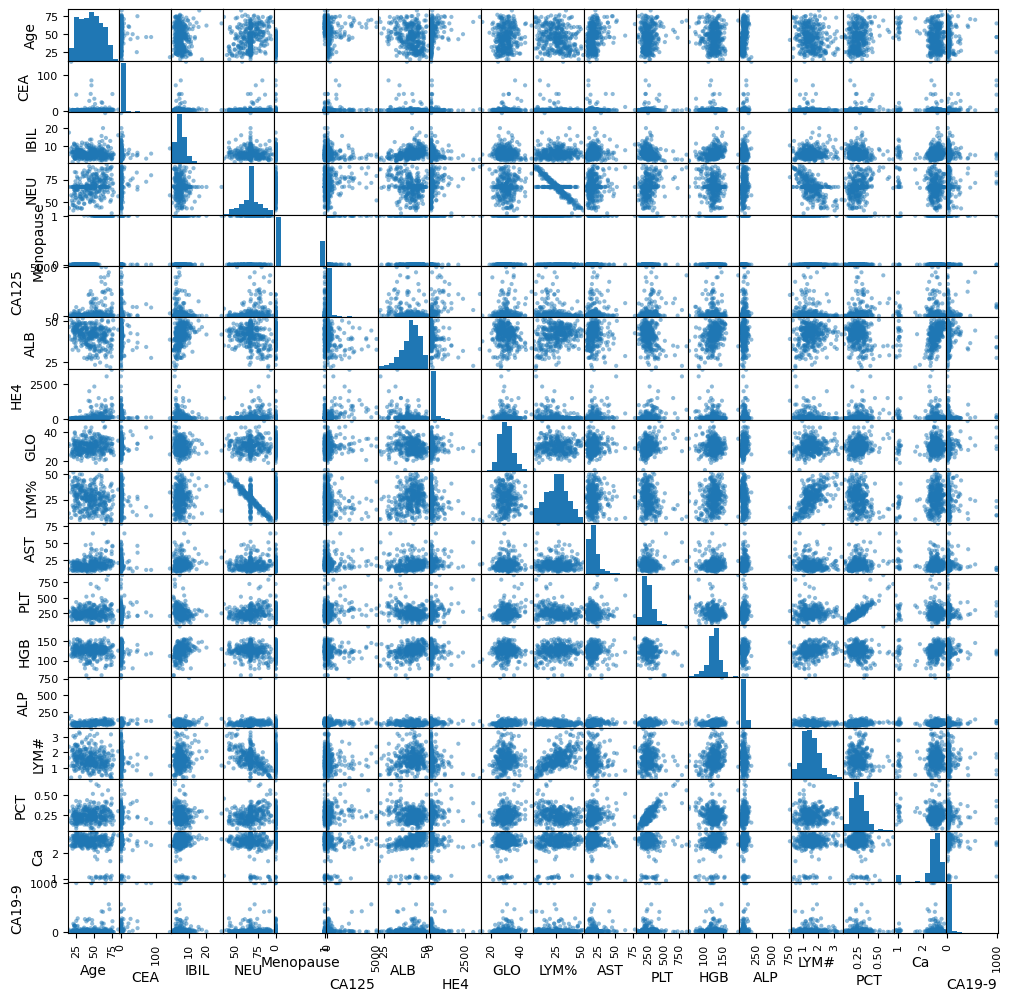

In [17]:
import matplotlib.pyplot as plt

# Create scatter plot matrix
pd.plotting.scatter_matrix(cancer_data[selected_features], figsize=(12, 12))
plt.show()

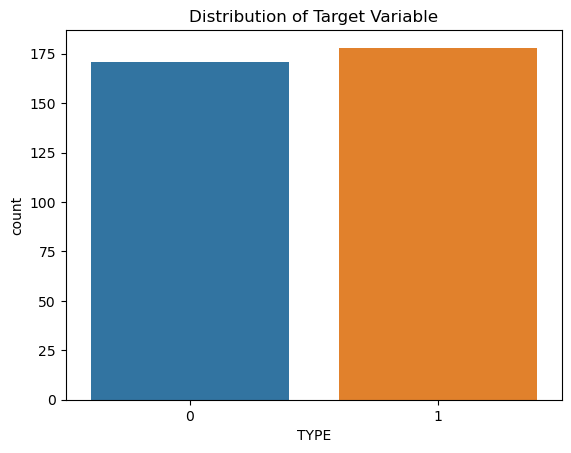

In [18]:
# Visualizing the distribution of the target variable in the training data
target_variable = cancer_data['TYPE']
sns.countplot(x=target_variable, data=cancer_data)
plt.title('Distribution of Target Variable')
plt.show()

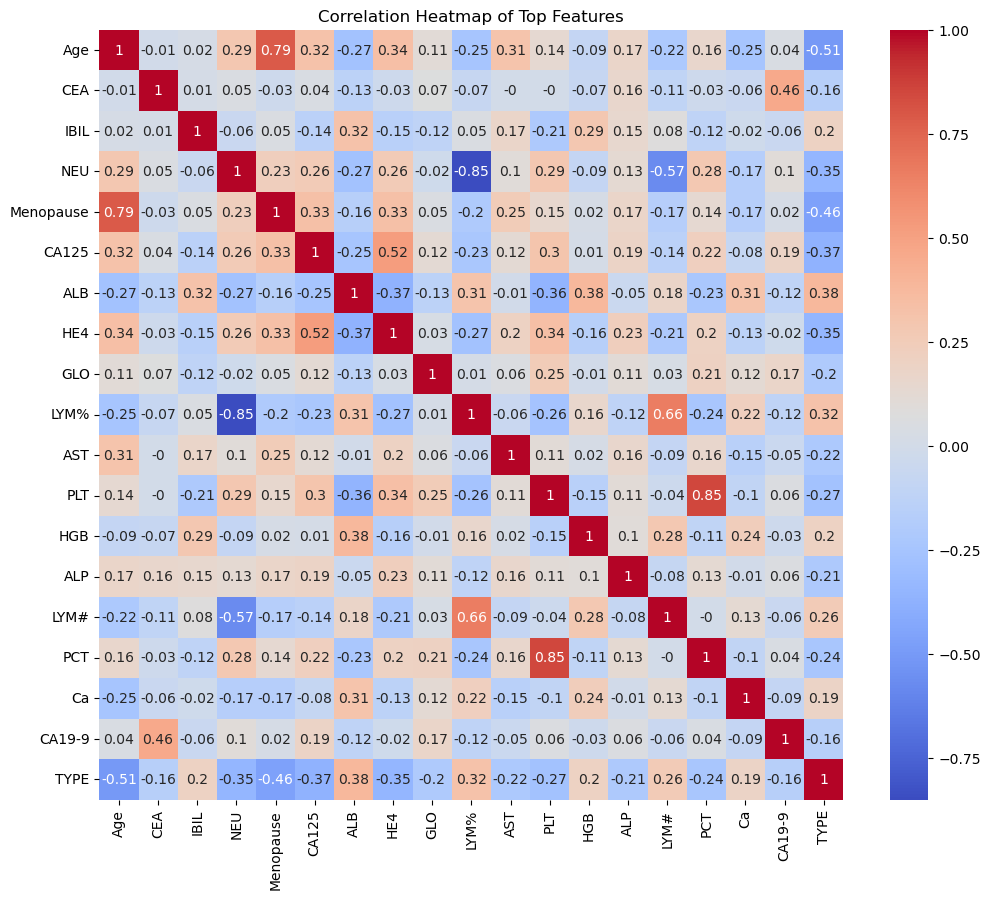

In [19]:
import seaborn as sns
# Create a correlation matrix
corr_matrix = np.around(cancer_data[selected_cols].corr(), 2)

# Plot the heatmap using seaborn
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top Features')
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Count'>

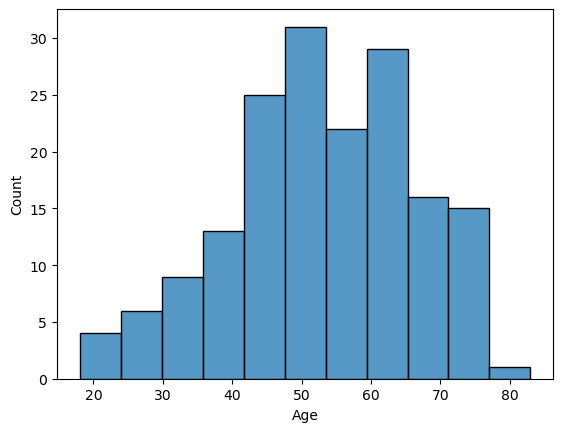

In [20]:
# Filter the data to only include positive values of the "TYPE" target column
positive_data = cancer_data[cancer_data['TYPE'] == 0]

# Create histogram using Seaborn
sns.histplot(data=positive_data, x="Age")

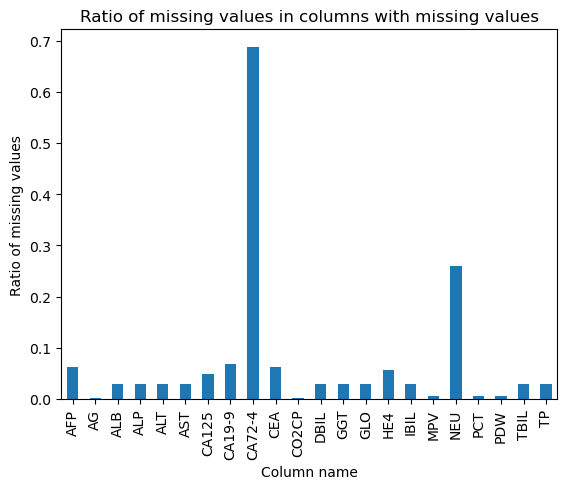

In [21]:
# calculate ratio of missing values in each column
missing_ratio = cancer_data_missing.isnull().sum() / len(cancer_data_missing)

# filter columns with missing values
missing_ratio = missing_ratio[missing_ratio > 0]

# plot the bar chart
missing_ratio.plot(kind='bar')
plt.title('Ratio of missing values in columns with missing values')
plt.xlabel('Column name')
plt.ylabel('Ratio of missing values')
plt.show()

### Model Training <a class="anchor" id="training"></a>

This section of the code involves using machine learning algorithms to build predictive models for detecting ovarian cancer. This section includes selecting appropriate algorithms and splitting the data into training and testing sets, training the models on the training data, and evaluating their performance on the testing data.

The goal of this section is to identify the most accurate and effective ensemble learning method(s) for detecting ovarian cancer. Ensemble learning is a machine learning technique that involves combining multiple models (called base models) to improve the overall performance and accuracy of predictions.

****Base Models Checked:**
1. SVM
2. KNN
3. Decision Trees

**Ensemble Learning Techniques Checked:**
1. Max Voting
2. Stacking
3. Bagging
4. Boosting
5. Stacking of Various Ensemble Learning Techniques

In [22]:
# from sklearn.model_selection import train_test_split
# X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(cancer_X_train, cancer_y_train, test_size=0.3, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(cancer_X_train, cancer_y_train, test_size=0.3, random_state=42)
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# print(cancer_X_train, cancer_y_train)
print(selected_features)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# Assuming cancer_X_train and cancer_y_train are your datasets
# Step 1: Train-Test Split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(cancer_X_train, cancer_y_train, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(cancer_X_train, cancer_y_train, test_size=0.3, random_state=42)
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(type(X_train))
# Step 3: Remove Outliers using Isolation Forest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train_raw)
mask = yhat != -1
X_train_no_outliers, y_train_no_outliers = X_train_raw[mask], y_train_raw[mask]

# Apply the same to the test set
yhat_test = iso.predict(X_test_raw)
mask_test = yhat_test != -1
X_test_no_outliers, y_test_no_outliers = X_test_raw[mask_test], y_test_raw[mask_test]

# Step 4: Apply PCA
pca = PCA(n_components=10)  # Reduce to 10 dimensions
X_train_pca = pca.fit_transform(X_train_no_outliers)
X_test_pca = pca.transform(X_test_no_outliers)

# Step 5: Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_no_outliers)
X_test_tsne = tsne.fit_transform(X_test_no_outliers)




['Age', 'CEA', 'IBIL', 'NEU', 'Menopause', 'CA125', 'ALB', 'HE4', 'GLO', 'LYM%', 'AST', 'PLT', 'HGB', 'ALP', 'LYM#', 'PCT', 'Ca', 'CA19-9']
<class 'pandas.core.frame.DataFrame'>


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the logistic regression prediction function
def predict_ovarian_cancer(CEA, HE4):
    logit = -4.111 + 0.369 * CEA + 0.055 * HE4
    probability = np.exp(logit) / (1 + np.exp(logit))
    return (probability <= 0.5).astype(int)  # Threshold at 0.5 for binary classification

# Custom accuracy scoring function
def acc_score_formular(df, label):
    # Ensure the feature columns exist in the DataFrame
    if 'CEA' not in df.columns or 'HE4' not in df.columns:
        raise KeyError("Columns 'CEA' and 'HE4' must be present in the DataFrame")
    
    # Extract features CEA and HE4
    CEA = df['CEA']
    HE4 = df['HE4']
    
    # True labels
    Y_true = label
    
    # Predict using the custom logistic regression formula
    predictions = predict_ovarian_cancer(CEA, HE4)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_true, predictions)
    
    # Calculate confusion matrix
    cm = confusion_matrix(Y_true, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Return accuracy, sensitivity, and specificity as a DataFrame
    Score = pd.DataFrame({
        "Classifier": ["Custom Logistic Regression"], 
        "Accuracy": [accuracy], 
        "Sensitivity": [sensitivity], 
        "Specificity": [specificity]
    })
    return Score

label = 'TYPE'

# Call the accuracy scoring function
score_df = acc_score_formular(X_test_raw, y_test_raw)
print(score_df)
score_df = acc_score_formular(X_test_no_outliers, y_test_no_outliers)
print(score_df)


                   Classifier  Accuracy  Sensitivity  Specificity
0  Custom Logistic Regression       0.8     0.923077     0.679245
                   Classifier  Accuracy  Sensitivity  Specificity
0  Custom Logistic Regression  0.824742         0.94     0.702128


Accuracy: 79.05%


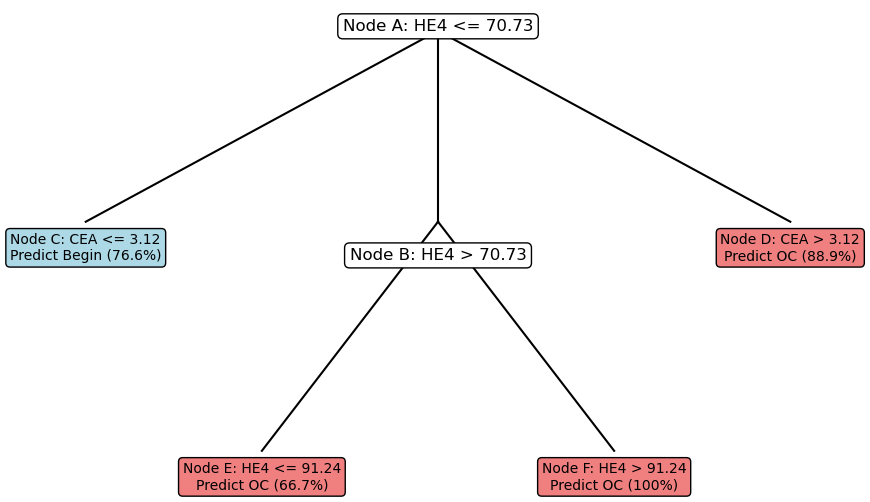

In [24]:
import pandas as pd

def cart_decision_tree(data):
    predictions = []
    for _, row in data.iterrows():
        if row['HE4'] <= 70.73:
            if row['CEA'] <= 3.12:
                predictions.append(1)  # Node C: Predict Begin
            else:
                predictions.append(0)  # Node D: Predict OC
        else:
            if row['HE4'] <= 91.24:
                predictions.append(0)  # Node E: Predict OC
            else:
                predictions.append(0)  # Node F: Predict OC
    return predictions

# Assuming X_test_raw is a pandas DataFrame and y_test_raw is a pandas Series or DataFrame
y_pred = cart_decision_tree(X_test_raw)

# Calculate accuracy
accuracy = (y_pred == y_test_raw).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# Define the decision tree rules
rules = {
    'Node A': {
        'rule': 'HE4 <= 70.73',
        'left': {
            'Node C': 'CEA <= 3.12: Predict Begin (76.6%)'
        },
        'right': {
            'Node D': 'CEA > 3.12: Predict OC (88.9%)'
        }
    },
    'Node B': {
        'rule': 'HE4 > 70.73',
        'left': {
            'Node E': 'HE4 <= 91.24: Predict OC (66.7%)'
        },
        'right': {
            'Node F': 'HE4 > 91.24: Predict OC (100%)'
        }
    }
}

# Plotting the tree
fig, ax = plt.subplots(figsize=(10, 6))

# Draw the nodes and edges
ax.text(0.5, 1, 'Node A: HE4 <= 70.73', ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white'))
ax.text(0.2, 0.7, 'Node C: CEA <= 3.12\nPredict Begin (76.6%)', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue'))
ax.text(0.8, 0.7, 'Node D: CEA > 3.12\nPredict OC (88.9%)', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral'))
ax.text(0.5, 0.7, 'Node B: HE4 > 70.73', ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white'))
ax.text(0.35, 0.4, 'Node E: HE4 <= 91.24\nPredict OC (66.7%)', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral'))
ax.text(0.65, 0.4, 'Node F: HE4 > 91.24\nPredict OC (100%)', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral'))

# Draw the connecting lines
ax.plot([0.5, 0.2], [1, 0.75], 'k-')
ax.plot([0.5, 0.8], [1, 0.75], 'k-')
ax.plot([0.5, 0.5], [1, 0.75], 'k-')
ax.plot([0.5, 0.35], [0.75, 0.45], 'k-')
ax.plot([0.5, 0.65], [0.75, 0.45], 'k-')

ax.axis('off')
plt.show()



In [25]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting']
models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

def acc_score(X_train, X_test, Y_train, Y_test, classifiers, models):
    Score = pd.DataFrame({"Classifier": classifiers})
    acc = []
    specificity = []
    sensitivity = []

    for model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        # Accuracy
        acc.append(accuracy_score(Y_test, predictions))
        
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
        
        # Specificity
        spec = tn / (tn + fp)
        specificity.append(spec)
        
        # Sensitivity (Recall)
        sens = recall_score(Y_test, predictions)
        sensitivity.append(sens)

    Score["Accuracy"] = acc
    Score["Specificity"] = specificity
    Score["Sensitivity"] = sensitivity
    
    Score.sort_values(by="Accuracy", ascending=False, inplace=True)
    Score.reset_index(drop=True, inplace=True)
    
    return Score


In [26]:
print(X_train_no_outliers.shape)
scores = acc_score(X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers, classifiers, models)
print(scores)

(219, 48)
         Classifier  Accuracy  Specificity  Sensitivity
0      RandomForest  0.896907     0.872340         0.92
1          AdaBoost  0.865979     0.829787         0.90
2  GradientBoosting  0.865979     0.851064         0.88
3          Logistic  0.835052     0.808511         0.86
4         LinearSVM  0.804124     0.765957         0.84
5      DecisionTree  0.804124     0.787234         0.82
6        KNeighbors  0.804124     0.744681         0.86
7         RadialSVM  0.711340     0.489362         0.92


In [27]:
print(X_train_raw.shape)
scores = acc_score(X_train_raw, X_test_raw, y_train_raw, y_test_raw, classifiers, models)
print(scores)

(244, 48)
         Classifier  Accuracy  Specificity  Sensitivity
0      RandomForest  0.885714     0.867925     0.903846
1  GradientBoosting  0.866667     0.849057     0.884615
2         LinearSVM  0.847619     0.811321     0.884615
3          AdaBoost  0.838095     0.849057     0.826923
4          Logistic  0.819048     0.773585     0.865385
5      DecisionTree  0.790476     0.830189     0.750000
6        KNeighbors  0.771429     0.716981     0.826923
7         RadialSVM  0.685714     0.452830     0.923077


In [28]:
print(X_train.shape)
scores = acc_score(X_train, X_test, y_train, y_test, classifiers, models)
print(scores)

(244, 18)
         Classifier  Accuracy  Specificity  Sensitivity
0      RandomForest  0.885714     0.849057     0.923077
1          Logistic  0.866667     0.849057     0.884615
2          AdaBoost  0.866667     0.886792     0.846154
3         LinearSVM  0.847619     0.830189     0.865385
4  GradientBoosting  0.838095     0.849057     0.826923
5      DecisionTree  0.819048     0.849057     0.788462
6        KNeighbors  0.771429     0.698113     0.846154
7         RadialSVM  0.685714     0.471698     0.903846


In [29]:
n_components_list = [10, 15, 20, 25, 30, 35, 40]

# Initialize lists to store results
accuracies = []
specificities = []
sensitivities = []
def evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers, models):
    scores = acc_score(X_train, X_test, y_train, y_test, classifiers, models)
    return scores
# Loop over different numbers of components
for n_components in n_components_list:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_no_outliers)
    X_test_pca = pca.transform(X_test_no_outliers)
    
    # Evaluate classifiers
    scores = evaluate_classifiers(X_train_pca, X_test_pca, y_train_no_outliers, y_test_no_outliers, classifiers, models)
    
    # Extract scores
    accuracy = scores['Accuracy']
    specificity = scores['Specificity']
    sensitivity = scores['Sensitivity']
    
    # Append scores to lists
    accuracies.append(accuracy)
    specificities.append(specificity)
    sensitivities.append(sensitivity)



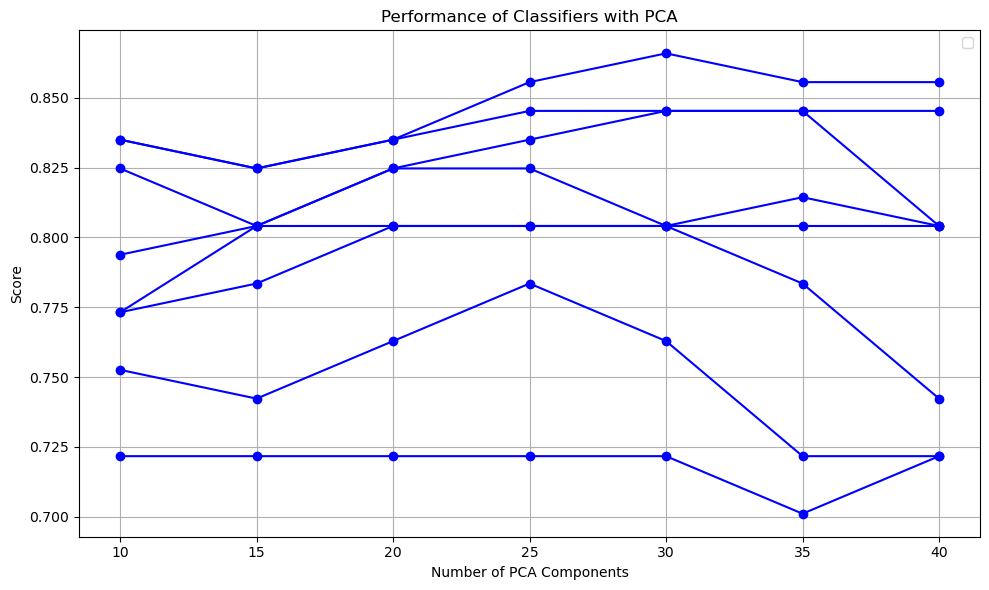

In [30]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, accuracies, marker='o', linestyle='-', color='b')
plt.title('Performance of Classifiers with PCA')
plt.xlabel('Number of PCA Components')
plt.ylabel('Score')
plt.xticks(n_components_list)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

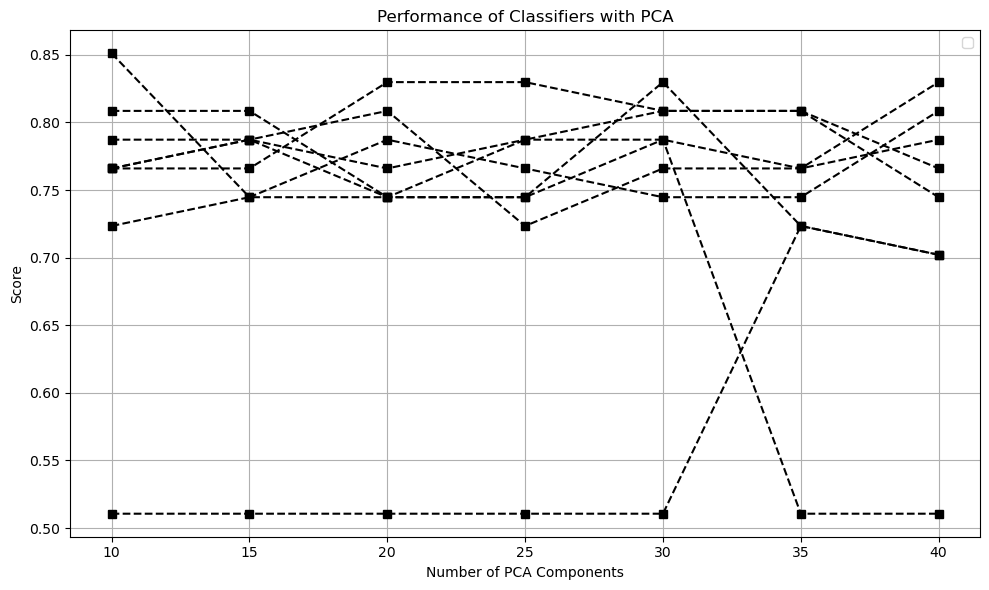

In [31]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, specificities, marker='s', linestyle='--', color='black')
plt.title('Performance of Classifiers with PCA')
plt.xlabel('Number of PCA Components')
plt.ylabel('Score')
plt.xticks(n_components_list)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

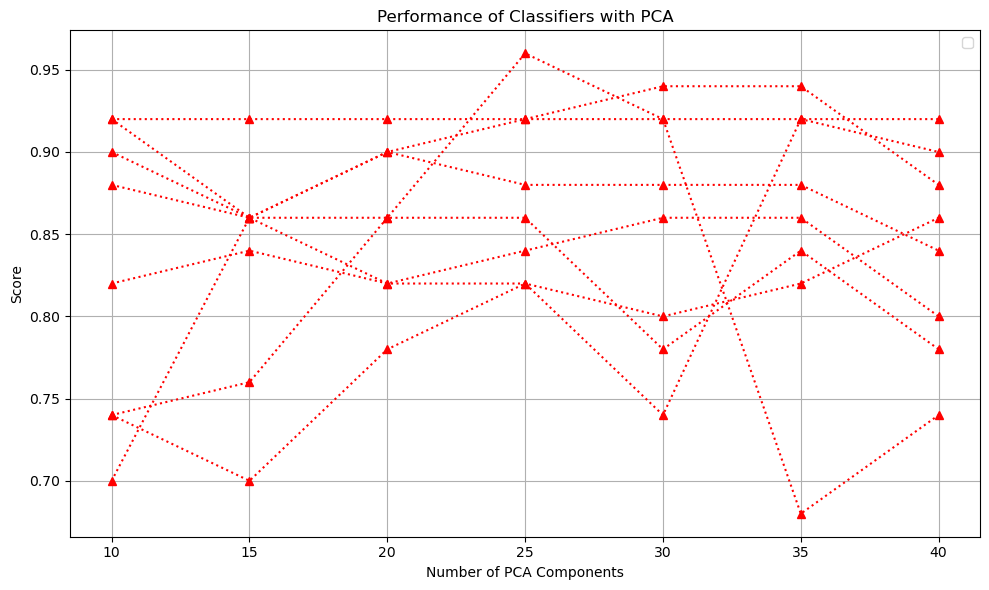

In [32]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, sensitivities, marker='^', linestyle=':', color='red')
plt.title('Performance of Classifiers with PCA')
plt.xlabel('Number of PCA Components')
plt.ylabel('Score')
plt.xticks(n_components_list)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
print(X_train_pca.shape, y_train_raw.shape)
scores = acc_score(X_train_tsne, X_test_tsne, y_train_no_outliers, y_test_no_outliers, classifiers, models)
print(scores)

(219, 40) (244,)
         Classifier  Accuracy  Specificity  Sensitivity
0         LinearSVM  0.556701     0.468085         0.64
1          Logistic  0.546392     0.489362         0.60
2         RadialSVM  0.525773     0.319149         0.72
3      DecisionTree  0.515464     0.468085         0.56
4        KNeighbors  0.494845     0.382979         0.60
5          AdaBoost  0.484536     0.510638         0.46
6      RandomForest  0.453608     0.425532         0.48
7  GradientBoosting  0.453608     0.510638         0.40


In [34]:
from sklearn.feature_selection import SelectKBest, f_classif
scores = []
for k in range(1, X_train_no_outliers.shape[1] + 1):
    # Select top k features
    selector = SelectKBest(f_classif, k=k)
    X_train_feature = selector.fit_transform(X_train_no_outliers, y_train_no_outliers)
    X_test_feature = selector.transform(X_test_no_outliers)
    
    # Compute accuracy score
    score = acc_score(X_train_feature, X_test_feature, y_train_no_outliers, y_test_no_outliers, classifiers, models)
    scores.append(score)
#     print(f"Number of features: {k}, Accuracy score: {score}")

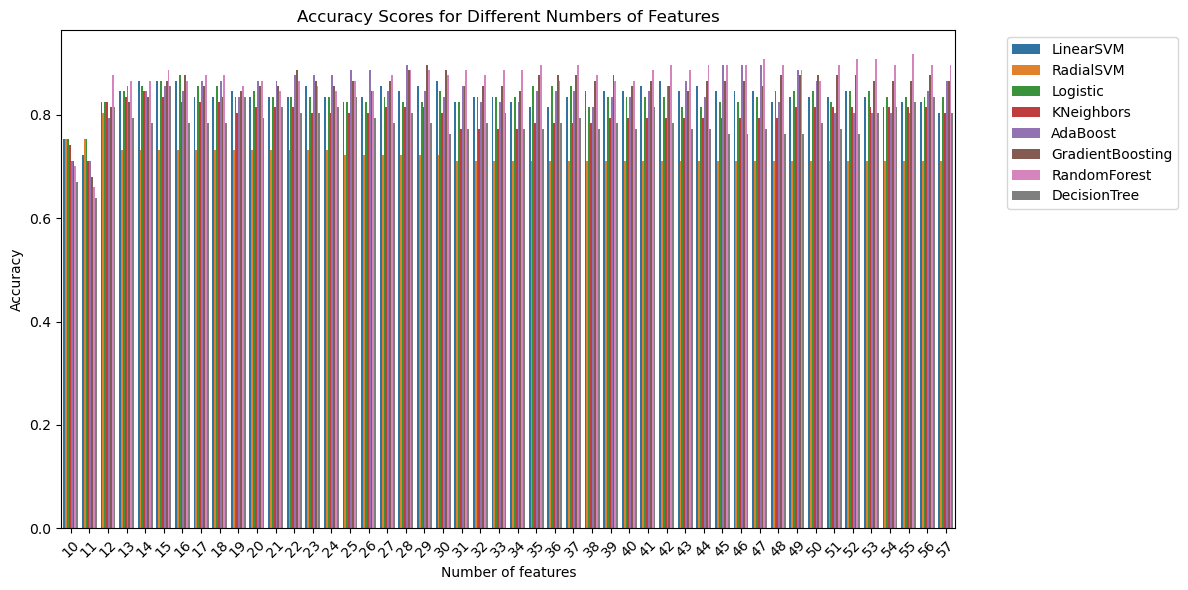

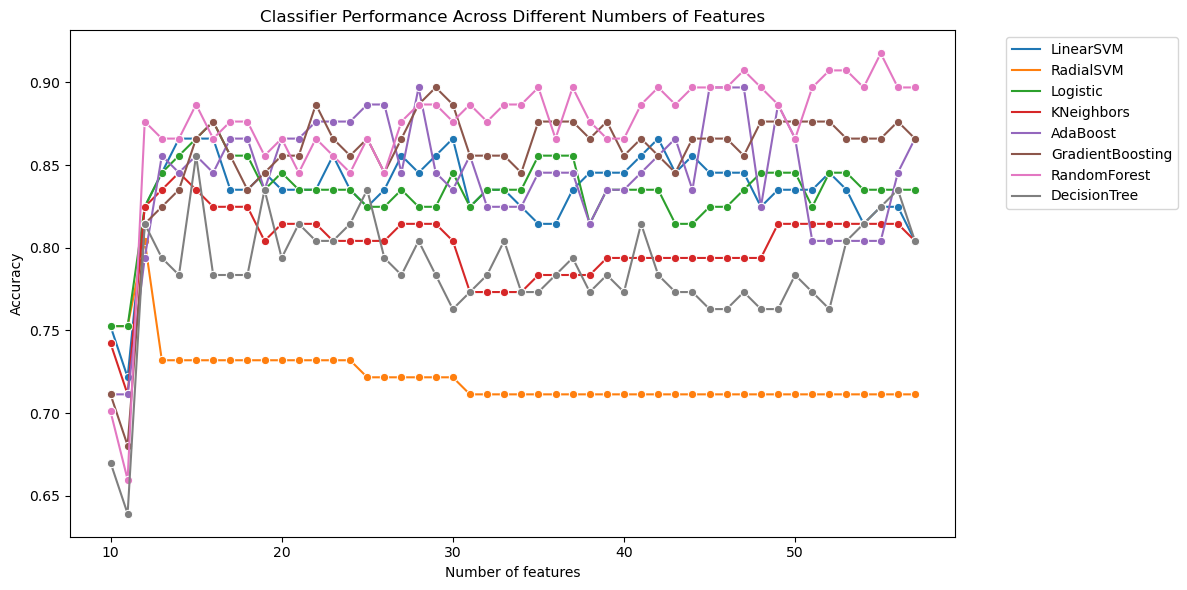

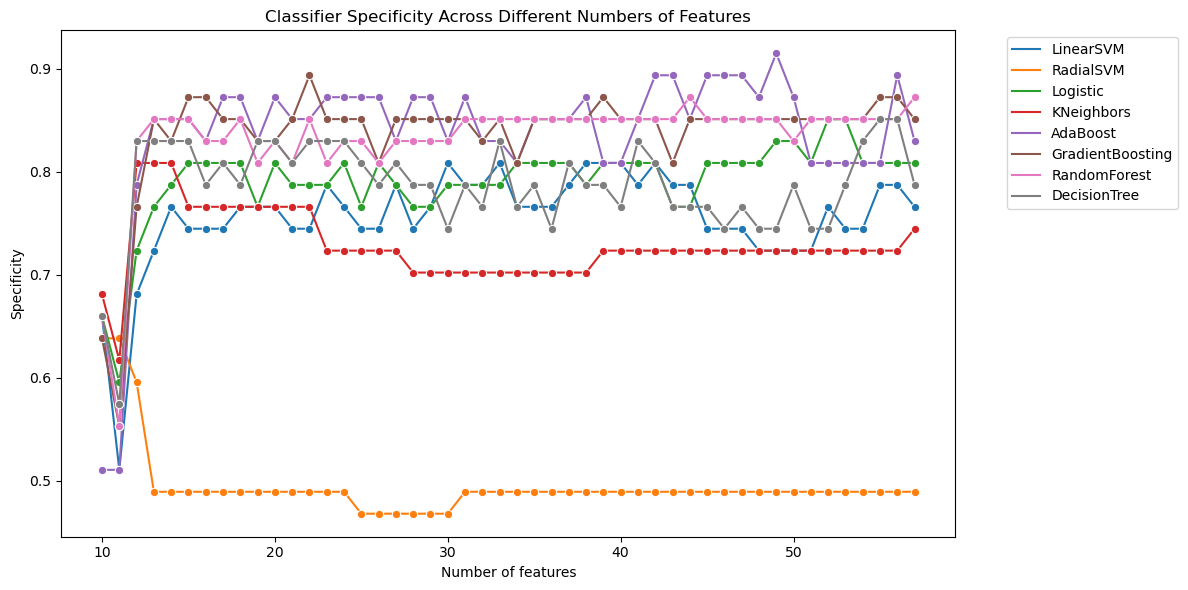

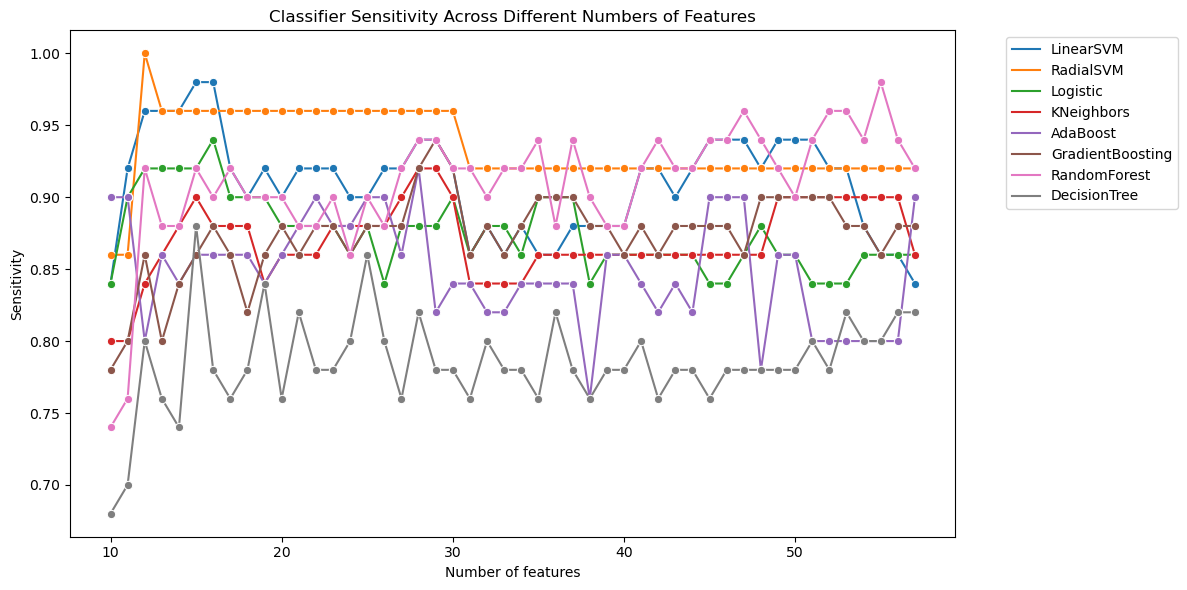

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `scores` is a list of DataFrames with classifier results for each number of features

# Concatenate all score DataFrames into one for easier plotting
results_df = pd.concat(scores, keys=range(10, 10 + len(scores)))

# Reset index to have 'Number of features' as a column
results_df.reset_index(level=0, inplace=True)
results_df.rename(columns={"level_0": "Number of features"}, inplace=True)

# Plot the accuracy scores for different numbers of features
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Number of features", y="Accuracy", hue="Classifier")
plt.title("Accuracy Scores for Different Numbers of Features")
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Line plot to compare the performance of different classifiers across different numbers of features
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Number of features", y="Accuracy", hue="Classifier", marker="o")
plt.title("Classifier Performance Across Different Numbers of Features")
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Specificity plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Number of features", y="Specificity", hue="Classifier", marker="o")
plt.title("Classifier Specificity Across Different Numbers of Features")
plt.ylabel("Specificity")
plt.xlabel("Number of features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Sensitivity plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Number of features", y="Sensitivity", hue="Classifier", marker="o")
plt.title("Classifier Sensitivity Across Different Numbers of Features")
plt.ylabel("Sensitivity")
plt.xlabel("Number of features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [36]:
#  Create a dataframe to store the accuracy of base models for further analysis
basemodel_df = pd.DataFrame(columns=['Base Model', 'Accuracy'])

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Training the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicting the target values for test data
test_preds = svm_model.predict(X_test)

accuracy = svm_model.score(X_test, y_test)
basemodel_df = basemodel_df.append({'Base Model': "SVM", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("SVM:")
print(classification_report(y_test, test_preds))

SVM:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        53
           1       0.83      0.87      0.85        52

    accuracy                           0.85       105
   macro avg       0.85      0.85      0.85       105
weighted avg       0.85      0.85      0.85       105



In [38]:
from sklearn.neighbors import KNeighborsClassifier

# create KNN classifier
knn = KNeighborsClassifier()
# train the model
knn.fit(X_train, y_train)

# Predicting the target values for test data
test_preds = knn.predict(X_test)

accuracy = knn.score(X_test, y_test)
basemodel_df = basemodel_df.append({'Base Model': "KNN", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("KNN:")
print(classification_report(y_test, test_preds))

KNN:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        53
           1       0.73      0.85      0.79        52

    accuracy                           0.77       105
   macro avg       0.78      0.77      0.77       105
weighted avg       0.78      0.77      0.77       105



In [39]:
from sklearn.tree import DecisionTreeClassifier

# create decision tree classifier
clf = DecisionTreeClassifier(random_state=0)

# fit the model to the training data
clf.fit(X_train, y_train)

# predict on the test data
y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
basemodel_df = basemodel_df.append({'Base Model': "Decision Tree", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("Decision Trees:")
print(classification_report(y_test, y_pred))

Decision Trees:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        53
           1       0.84      0.79      0.81        52

    accuracy                           0.82       105
   macro avg       0.82      0.82      0.82       105
weighted avg       0.82      0.82      0.82       105



In [40]:
from sklearn.metrics import accuracy_score

#  Create a dataframe to store the accuracy of ensemble models for further analysis
ensemble_df = pd.DataFrame(columns=['Ensemble Model', 'Accuracy'])

In [41]:
# importing voting classifier
from sklearn.ensemble import VotingClassifier

# Making the final model using voting classifier
vote_model = VotingClassifier(estimators=[('svc', svm_model), ('knn', knn), ('tree', clf)], voting='hard')

# training all the model on the train dataset
vote_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = vote_model.predict(X_test)

accuracy = vote_model.score(X_test, y_test)
ensemble_df = ensemble_df.append({'Ensemble Model': "Max Voting", 'Accuracy': accuracy}, ignore_index=True)

# evaluate the model on the test set
print("Max Voting:")
print(classification_report(y_test, pred_final))

Max Voting:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        53
           1       0.83      0.87      0.85        52

    accuracy                           0.85       105
   macro avg       0.85      0.85      0.85       105
weighted avg       0.85      0.85      0.85       105



In [42]:
# importing stacking lib for Stack Method
from vecstack import stacking
 
# putting all base model objects in one list
all_models = [svm_model, clf, knn]
 
# computing the stack features
s_train, s_test = stacking(all_models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           n_folds=5,                  # number of folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=1)                  # print all info
 
# initializing the second-level model
final_model = clf
 
# fitting the second level model with stack features
final_model = final_model.fit(s_train, y_train)
 
# predicting the final output using stacking
pred_final = final_model.predict(s_test)
 
accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Stacking", 'Accuracy': accuracy}, ignore_index=True)


# calculate accuracy score
# evaluate the model on the test set
print("Stacking:")
print(classification_report(y_test, pred_final))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVC]
    ----
    MEAN:     [0.81113946] + [0.05545391]
    FULL:     [0.81147541]

model  1:     [DecisionTreeClassifier]
    ----
    MEAN:     [0.79923469] + [0.04700805]
    FULL:     [0.79918033]

model  2:     [KNeighborsClassifier]
    ----
    MEAN:     [0.79506803] + [0.04284229]
    FULL:     [0.79508197]

Stacking:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        53
           1       0.81      0.88      0.84        52

    accuracy                           0.84       105
   macro avg       0.84      0.84      0.84       105
weighted avg       0.84      0.84      0.84       105



In [43]:
# importing bagging module for Bagging Method
from sklearn.ensemble import BaggingClassifier

# initializing the bagging model using XGboost as base model with default parameters
bag_model = BaggingClassifier(base_estimator=svm_model)
 
# training model
bag_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred = bag_model.predict(X_test)
pred = np.around(pred).astype("int64") # convert probabilities to labels
 
# calculate accuracy score
 
accuracy = accuracy_score(y_test, pred)
ensemble_df = ensemble_df.append({'Ensemble Model': "Bagging", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Bagging:")
print(classification_report(y_test, pred))

Bagging:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        53
           1       0.85      0.85      0.85        52

    accuracy                           0.85       105
   macro avg       0.85      0.85      0.85       105
weighted avg       0.85      0.85      0.85       105



In [44]:
# importing machine learning models for prediction
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# initializing the boosting module with default parameters
model = GradientBoostingClassifier()
xgb_model = XGBClassifier()

# training the model on the train dataset
#model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# predicting the output on the test dataset
pred_final = xgb_model.predict(X_test)
 
accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Boosting", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Boosting:")
print(classification_report(y_test, pred_final))

Boosting:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        53
           1       0.88      0.85      0.86        52

    accuracy                           0.87       105
   macro avg       0.87      0.87      0.87       105
weighted avg       0.87      0.87      0.87       105



In [45]:
# Combining all ensemble models; (bagging, boosting, max_vote) with stacking
# importing stacking lib
from vecstack import stacking
 
# putting all base model objects in one list
all_models = [xgb_model, vote_model, bag_model]
 
# computing the stack features
s_train, s_test = stacking(all_models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           n_folds=5,                  # number of folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=1)                  # print all info
 
# initializing the second-level model
final_model = xgb_model
 
# fitting the second level model with stack features
final_model = final_model.fit(s_train, y_train)
 
# predicting the final output using stacking
pred_final = final_model.predict(s_test)
 
# calculate accuracy score
 
accuracy = accuracy_score(y_test, pred_final)
ensemble_df = ensemble_df.append({'Ensemble Model': "Ensemble Combination", 'Accuracy': accuracy}, ignore_index=True)


# evaluate the model on the test set
print("Stacking:")
print(classification_report(y_test, pred_final))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    ----
    MEAN:     [0.86479592] + [0.03542154]
    FULL:     [0.86475410]

model  1:     [VotingClassifier]
    ----
    MEAN:     [0.82772109] + [0.04820941]
    FULL:     [0.82786885]

model  2:     [BaggingClassifier]
    ----
    MEAN:     [0.81930272] + [0.05253561]
    FULL:     [0.81967213]

Stacking:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        53
           1       0.86      0.94      0.90        52

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105



### Analysis of Ensemble Methods <a class="anchor" id="model_anal"></a>

This section of the code involves evaluating the performance of the ensemble learning methods used in the model training section, by using appropriate evaluation metrics and comparing the results. The purpose is to determine the most effective and efficient method for detecting ovarian cancer tumors and to identify the factors that contribute to the superior performance of a particular ensemble learning technique over others.

In [46]:
# select top 10 features using mRMR
from mrmr import mrmr_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(cancer_X_train, cancer_y_train, test_size=0.3, random_state=42)

In [47]:
# Create a dataframe to store the accuracy and corresponding number of features
accuracy_df = pd.DataFrame(columns=['Number of Features', 'Accuracy'])

# Loop over the number of features and train decision tree models on each subset
for n in range(2, 49):
    # Select the first n features from the list of selected features
    subset_features = mrmr_classif(X=cancer_X_train, y=cancer_y_train, K=n)
    
    # Train a decision tree model on the selected subset of features
    model = DecisionTreeClassifier()
    model.fit(cancer_X_train[subset_features], cancer_y_train)
    
    # Evaluate the model on the test set and store the accuracy
    accuracy = model.score(cancer_X_test[subset_features], cancer_y_test)
    accuracy_df = accuracy_df.append({'Number of Features': n, 'Accuracy': accuracy}, ignore_index=True)
    
# Print the resulting dataframe
print(accuracy_df)

100%|██████████| 48/48 [00:02<00:00, 20.23it/s]

    Number of Features  Accuracy
0                  2.0  0.590476
1                  3.0  0.600000
2                  4.0  0.609524
3                  5.0  0.647619
4                  6.0  0.771429
5                  7.0  0.838095
6                  8.0  0.733333
7                  9.0  0.733333
8                 10.0  0.790476
9                 11.0  0.761905
10                12.0  0.780952
11                13.0  0.800000
12                14.0  0.790476
13                15.0  0.828571
14                16.0  0.800000
15                17.0  0.780952
16                18.0  0.771429
17                19.0  0.790476
18                20.0  0.809524
19                21.0  0.800000
20                22.0  0.790476
21                23.0  0.752381
22                24.0  0.771429
23                25.0  0.809524
24                26.0  0.790476
25                27.0  0.809524
26                28.0  0.800000
27                29.0  0.790476
28                30.0  0.790476
29        

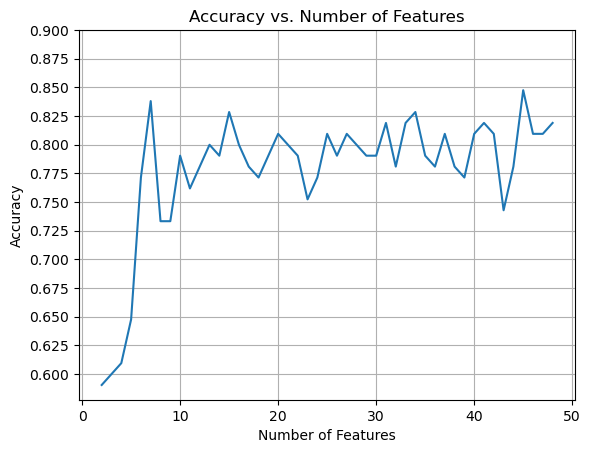

In [48]:
# plot the accuracy against number of features
plt.plot(accuracy_df['Number of Features'], accuracy_df['Accuracy'])
plt.title('Accuracy vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.6, 0.9, 0.025))
plt.grid(True)
plt.show()

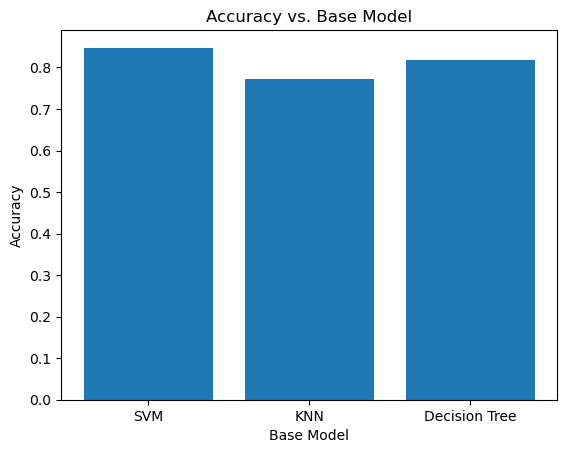

In [49]:
plt.bar(basemodel_df['Base Model'], basemodel_df['Accuracy'])
plt.title('Accuracy vs. Base Model')
plt.xlabel('Base Model')
plt.ylabel('Accuracy')
plt.show()

the SVM algorithm provided the best performancec among the 3. The major evaluation metric 
used for comparison was accuracy, which is the proportion of correctly classified instances.

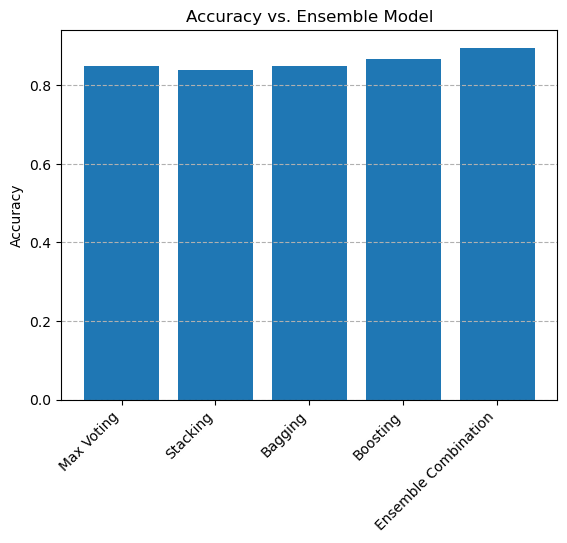

In [50]:
# create bar plot
fig, ax = plt.subplots()
ax.bar(ensemble_df['Ensemble Model'], ensemble_df['Accuracy'])

# set x-axis tick labels
ax.set_xticklabels(ensemble_df['Ensemble Model'], rotation=45, ha='right')

# add grid lines
ax.grid(axis='y', linestyle='--')

# add axis labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Ensemble Model')

plt.show()

Even though the boosting method performed higher than the baseline models, it is discovered 
that an even higher performace can be gotten by combining the ensemble methods with one 
another.

### Explainable AI <a class="anchor" id="xai"></a>

This section of the code refers to the techniques and methods used to make machine learning models understandable to humans. It involves analyzing the model's inner workings and providing insights into how it makes predictions, allowing developers and stakeholders to understand and trust the model's output. By incorporating explainable AI techniques into the model, developers can ensure that it is not only accurate but also trustworthy and reliable.

XAI Techniques Used:
1. Feature Importance:
    * *eli5* Permutation Importance
    * SHAP Permutation Importance
2. Dependence Plots:
    * Partial Dependence Plot
    * SHAP Dependence Contribution Plot
3. SHAP Values Force Plot


### Feature Importance

Permutation importance is a method used to calculate the importance of each feature in a machine learning model. It involves permuting the values of a single feature in the dataset and then observing the effect on the model's accuracy. The feature that causes the largest decrease in accuracy when permuted is considered the most important feature.

In [51]:
# eli5 Permutation Importance
import eli5
from eli5.sklearn import PermutationImportance
model = xgb_model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1695 ± 0.0349,HE4
0.0800 ± 0.0748,NEU
0.0343 ± 0.0373,Age
0.0190 ± 0.0381,CA125
0.0095 ± 0.0120,LYM%
0.0076 ± 0.0076,CA19-9
0.0076 ± 0.0143,ALB
0.0038 ± 0.0093,PCT
0.0019 ± 0.0305,HGB
0.0000 ± 0.0120,AST


In [52]:
import shap

**SHAP permutation importance** is just like eli5's but this time it uses a summary plot to show it, giving more information than eli5's.

A summary plot is a visual representation of the SHAP permutation importance technique. It displays a list of the most important features in descending order, along with their respective SHAP values. The summary plot also includes a bar chart that shows the impact of each feature on the model's output, with positive values indicating that the feature contributes to higher predictions and negative values indicating the opposite. This helps to provide a clear and intuitive understanding of the relative importance of each feature in the model, and how it contributes to the final prediction.

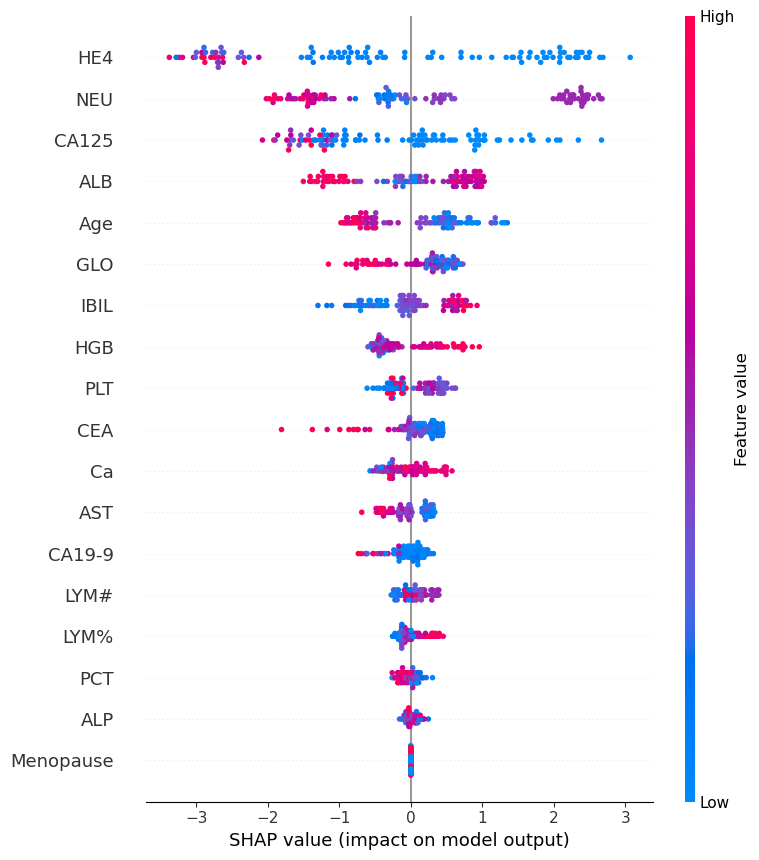

In [53]:
# SHAP Permutation Importance

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test)

### Dependence Plots

Dependence plots show how a single input feature affects the predicted output of a machine learning model while holding all other features constant. They provide insights into non-linear relationships and help to interpret the model.

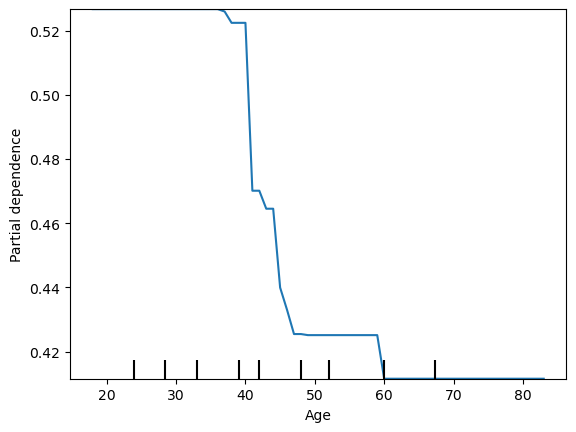

In [54]:
# Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay

disp1 = PartialDependenceDisplay.from_estimator(model, X_test, ['Age']) #CA125 is mentioned a lot in research
plt.show()

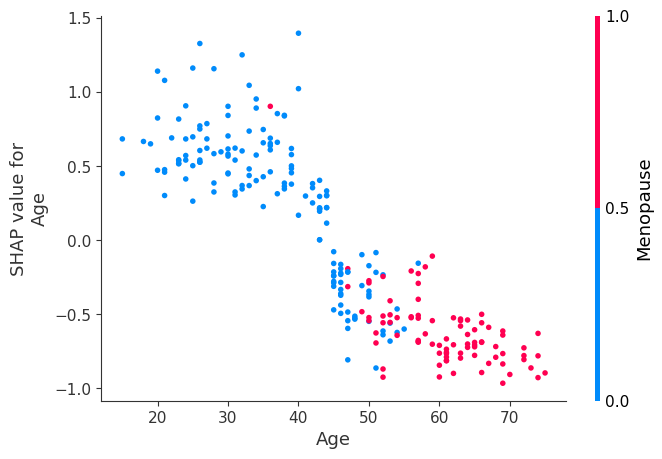

In [55]:
# SHAP Dependence Contribution Plot

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# make plot.
shap.dependence_plot('Age', shap_values, X_train, interaction_index="Menopause")

### SHAP Values Force Plot

SHAP values are based on the concept of Shapley values from cooperative game theory. They work by assigning a numerical value to each feature in a given prediction, which represents how much that feature contributed to the final prediction.

By examining a force plot, it is possible to see which features are pushing the prediction towards a certain outcome, and which features are pulling it in a different direction. This information can be used to gain insights into how the model is making predictions, and to identify which features are most important for a given observation.

In [56]:
row_to_show = 99
explainer = shap.TreeExplainer(model)
data_for_prediction = X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction.values.reshape(1, -1))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [57]:
row_to_show = 100
explainer = shap.TreeExplainer(model)
data_for_prediction = X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction.values.reshape(1, -1))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)